# Test the differents function
author : Sofiane Horache

In [63]:
# library used
import numpy as np
import pandas as pd
from utils.ply import *
from patch_decomp import *
from descriptor import * 
import matplotlib.pyplot as plt
from octree import *
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, f1_score
import itertools
import time
%matplotlib inline


In [2]:
# load data

filepath = "../data/GT_Madame1_2.ply"
data = read_ply(filepath)
xyz = np.vstack((data['x'], data['y'], data['z'])).T
label = data['class']

Size of the points cloud : (10000000, 3)
Number of class : 15
[  3.00000000e+00   4.76941700e+06   4.33305900e+06   0.00000000e+00
   7.90822000e+05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   3.65600000e+03   8.17450000e+04   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.14630000e+04   2.54200000e+03
   0.00000000e+00   0.00000000e+00   0.00000000e+00   3.03000000e+03
   9.83000000e+02   1.11000000e+02   1.91500000e+03   3.84000000e+02
   8.70000000e+02]


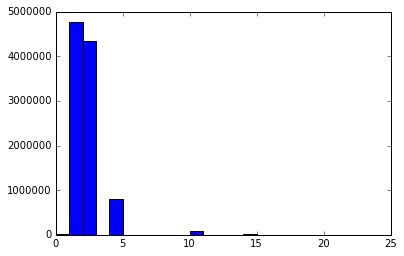

In [3]:
# print some info
print("Size of the points cloud :", xyz.shape)
print("Number of class :", len(np.unique(label)))
h = plt.hist(label.copy(), 25)
print(h[0])

conclusion: The classes are inequal, we will have to select the training set.
## 1] We create divide the points cloud into patches

The problem here is the author didn't precise how we extract the patches. Maybe the patches have a kind of shape. So We suppose patches are just a group of points in a square of fixed size. We will not use the PCS.

In [4]:
# We test here id_to_dic

a = 2 * np.random.randn(100000, 3)
p = pc_to_patches(a, 1)
id_p = patches_to_id(p, a.shape[0])
new_p = id_to_dic(id_p)
for k in p.keys():
    if(set(new_p[k])!= set(p[k])):
        print(error)
        
# It seems to work
# but it is long and useless

In [30]:
patches = pc_to_patches(xyz, 1) # very long !!!
id_patches = patches_to_id(patches, xyz.shape[0])
write_ply("../data/paris_patched.ply",np.hstack((xyz,
                                                 id_patches.reshape(-1,1),
                                                 label.reshape(-1, 1))),
          ['x', 'y', 'z', 'patches', 'class'])

ValueError: all the input arrays must have same number of dimensions

In [5]:
# In order to save time we load the label of the patches
data = read_ply('../data/paris_patched.ply')
xyz = np.vstack((data['x'], data['y'], data['z'])).T
y = data['class']
id_patches = data['patches']
#patches = id_to_dic(id_patches)

## 2]  computation of the descriptors
Here we will compute 
### 2.1 the octree structure

We will test the octree structure with a 3D sphere(gaussian law) and a cube(uniform low). We will also try for a plane and a line.

In [7]:
# LOD for a ball
%time
ball = np.random.randn(1000, 3)
tree = Octree(3, ball)
print("For a ball")
print("Number of cube per LOD :", tree.divide())

#LOD for a cube
cube = np.random.rand(1000, 3)
tree = Octree(3, cube)
print("For a a cube")
print("Number of cube per LOD :", tree.divide())

#LOD for a line
a, b = np.random.rand(2)
x = np.random.rand(1000, 1)
line = np.hstack((x, a*x, b*x))
tree = Octree(3, line)
print("For a line")
print("Number of cube per LOD :", tree.divide())

#LOD for two lines
a, b = np.random.rand(2)
x = np.random.rand(500, 1)
line1 = np.hstack((x, a*x, b*x))
a, b = np.random.rand(2)
line2 = np.hstack((x, a*x, b*x))
two_lines = np.vstack((line1, line2))
tree = Octree(3, two_lines)
print("For two lines")
print("Number of cube per LOD :", tree.divide())


#LOD for a horizontal plane
a, b = np.random.rand(2)
xy = np.random.rand(1000, 2)
plane = np.hstack((xy, (0*xy[:, 0]+b*xy[:, 1]).reshape(-1, 1)))
tree = Octree(3, plane)
print("For a horizontal plane")
print("Number of cube per LOD :", tree.divide())

#LOD for a diagonal plane
a, b = np.random.rand(2)
xy = np.random.rand(1000, 2)
plane = np.hstack((xy, (a*xy[:, 0]+b*xy[:, 1]).reshape(-1, 1)))
tree = Octree(3, plane)
print("For a diagonal plane")
print("Number of cube per LOD :", tree.divide())

#LOD for 2 planes

a, b = np.random.rand(2)
xy = np.random.rand(500, 2)
plane1 = np.hstack((xy, (a*xy[:, 0]+b*xy[:, 1]).reshape(-1, 1)))
a, b = np.random.rand(2)
plane2 = np.hstack((xy, (a*xy[:, 0]+b*xy[:, 1]).reshape(-1, 1)))
two_planes = np.vstack((plane1, plane2))
tree = Octree(3, two_planes)
print("For two planes")
print("Number of cube per LOD :", tree.divide())


 


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs
For a ball
Number of cube per LOD : [   1.    8.   48.  211.]
For a a cube
Number of cube per LOD : [   1.    8.   64.  441.]
For a line
Number of cube per LOD : [ 1.  2.  4.  8.]
For two lines
Number of cube per LOD : [  1.   6.  11.  23.]
For a horizontal plane
Number of cube per LOD : [  1.   4.  16.  64.]
For a diagonal plane
Number of cube per LOD : [   1.    6.   25.  106.]
For two planes
Number of cube per LOD : [   1.    7.   38.  169.]


In [8]:
# We can compute feature for each patch
a, b = np.random.rand(2)
xy = np.random.rand(1000, 2)
plane = np.hstack((xy, (a*xy[:, 0]+b*xy[:, 1]).reshape(-1, 1)))
tree = Octree(3, plane)
ppl1 = tree.divide()
phi1 = tree.get_phi()


xy = 4+ np.random.rand(1000, 2)
#a, b = np.random.rand(2)
plane = np.hstack((xy, (4*a*xy[:, 0]+4*b*xy[:, 1]).reshape(-1, 1)))
tree = Octree(3, plane)
ppl2 = tree.divide()
phi2 = tree.get_phi()

#compare plan
for i in range(1,4):
    print("LOD %d:"%i)
    print(np.dot(phi1[i], phi1[i]))
    print(np.dot(phi2[i], phi2[i]))
    print(np.dot(phi1[i], phi2[i]))

# seems coherent

LOD 1:
6.0
6.0
6.0
LOD 2:
28.0
28.0
28.0
LOD 3:
110.0
111.0
105.0


Conclusion : for low dimension shape, we are rather robust to count the dimensions, but for 3D objects, we need a lot of points(see the cube or the ball). For the cube, as we have some holes(because of random variables. We don't have a full precision so the estimation is not 100% exact).
Theoretical consistency for a ball.

Also the problem will be if we have two shapes in our octree. Then the dimension is harder to guess

The second test is to see for each level which cube is non empty. the indexation is a bit weird. So we have to change it. We therefore have a way to compare the differents patches at each level

### 2.2 the descriptors

First we will labelize the patches using label binarize of sklearn

In [11]:
# a bit long
label_per_patch = labelize_patch(id_patches, y)
new_label = np.zeros(y.shape[0])
new_label = label_per_patch[id_patches]
write_ply("../data/paris_patch_label.ply",np.hstack((xyz,
                                                    id_patches.reshape(-1,1),
                                                   new_label.reshape(-1,1))),
         ['x', 'y', 'z', 'patches', 'new_label'])
print(np.sum(new_label==y)/y.shape[0])
a = confusion_matrix(np.array(new_label).astype(int), y)

/cal/softs/anaconda/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:973: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return argmax(axis, out)
/cal/softs/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


0.9697603


In [132]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/cal/softs/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


Normalized confusion matrix


/cal/softs/anaconda/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[ 0.          0.98593996  0.96592049  0.91021429  0.86696608  0.79535173
  0.87939359  0.91445553  0.84215501  0.381893    0.          0.92117465
  0.          0.37844941  0.32285115]


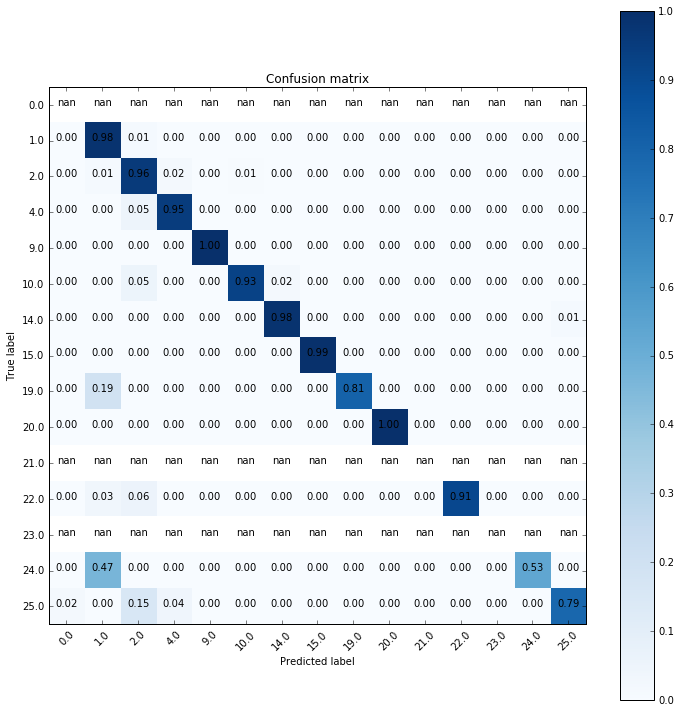

In [13]:
# We will compute confusion matrix to see if there are big mistakes
plt.figure(figsize=(10,10))
plot_confusion_matrix(a, np.unique(y), True)
print(f1_score(y, new_label, average=None))

We have some mistakes especially for rare items. We see here the error of quantification.

Now let us compute the ppl descriptors and the covariance descriptors.

In [86]:

# We will compute the ppl for each patches
data = read_ply("../data/paris_patch_label.ply")
df = pd.DataFrame(np.vstack((data['x'], data['y'], data['z'], data['patches'], data['new_label'])).T,
                 columns=['x', 'y', 'z', 'patches', 'label'])
new_y = data['new_label'] 
# How we have access to one point
point = df.loc[df.groupby('patches').groups[0],('x','y', 'z')].values


In [120]:
# Define function to apply for each patches
cov = lambda col:compute_covariance_feat(col.loc[:,('x','y', 'z')].values)
ppl = lambda col:compute_ppl_feat(col.loc[:,('x','y', 'z')].values)

In [121]:
## IT IS VERY LONG
print("compute cov coeff...")
start = time.time()
X_cov = np.vstack((df.groupby('patches').apply(cov).values))
print("Done in {0}".format(time.time()-start))
print('compute ppl coef...')
start = time.time()
X_ppl = np.vstack((df.groupby('patches').apply(ppl).values))
print("Done in {0}".format(time.time()-start))
# That's why we save the data
np.save('../data/feature_cov', X_cov)
np.save('../data/feature_ppl', X_ppl)

compute cov coeff...
Done in 61.08352470397949
compute ppl coef...
Done in 1889.160145521164


In [122]:
X_octree = np.load('../data/feature_ppl.npy')
X_cov = np.load('../data/feature_cov.npy')

print(X_cov.shape)
X_ppl = X_octree[:,:8]

# For the kernel
X_L1 = X_octree[:,8:16]
X_L2 = X_octree[:,16:80]
X_L3 = X_octree[:,80:592]
X_L4 = X_octree[:,592:]

(9942, 9)


[  1.   2.   4.   9.  10.  14.  15.  19.  20.  22.  24.  25.]


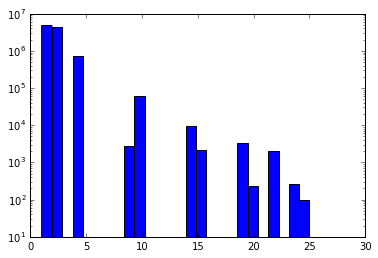

In [64]:
# We print the histogram of new_y
name_of_label = ["Background","Facade","Ground","Cars",
                 "Light poles","Pedestrians","Motorcycles",
                 "Traffic signs","Trash can","Wall Light","Balcony Plant",
                 "Parking meter","Fast pedestrian","Wall Sign",
                 "Pedestrian + something","Noise","Pot plant"]
print(np.unique(new_y))
u = plt.hist(new_y, log=True, bins= 26, align='mid')

## Classification

First, we are going to balance the class a bit more.

In [229]:
import xml
root = xml.etree.ElementTree.parse('../data/classes.xml').getroot()
dico = dict()

for child in root.iter('class'):
        dico[int(child.attrib['id'])] = child.attrib['en']

print(dico)

{0: 'unclassified', 100000000: 'other', 302020100: 'other punctual', 302030600: 'wire', 303020300: 'walking pedestrian', 303050000: 'furniture', 302030100: 'other linear', 200000000: 'surface', 303050500: 'trash can', 303030300: 'scooter', 303030301: 'other scooter', 300000000: 'object', 303030303: 'scooter with driver', 304020000: 'tree', 302030000: 'linear', 303040400: 'truck', 302020900: 'trash can', 304040000: 'potted plant', 303040300: 'van', 302020400: 'floor lamp', 302040200: 'shelter', 302030500: 'chain', 303040000: '4+ wheelers', 303020600: 'holding pedestrian', 202000000: 'ground', 303050400: 'stool', 303050300: 'chair', 302030400: 'grid', 202060000: 'vegetation', 302000000: 'static', 303020100: 'other pedestrian', 202050000: 'island', 302020800: 'mailbox', 302040400: 'scaffolding', 303030100: 'other 2 wheels', 303020900: 'rollerskater', 302020700: 'signboard', 203000000: 'building', 202010000: 'other ground', 303040100: 'other 4+ wheels', 302040000: 'extended', 304000000: 'n

In [230]:
for ind, cl in enumerate(np.unique(old_y_patch)):
    print(ind, cl, dico[int(cl)])

0 0.0 unclassified
1 202010000.0 other ground
2 202020000.0 road
3 202030000.0 sidewalk
4 202040000.0 curb
5 203000000.0 building
6 301000000.0 other object
7 302020300.0 bollard
8 302020400.0 floor lamp
9 302020600.0 traffic sign
10 302020900.0 trash can
11 302021000.0 meter
12 302030400.0 grid
13 303020000.0 pedestrian
14 303020200.0 still pedestrian
15 303020300.0 walking pedestrian
16 303020600.0 holding pedestrian
17 303030202.0 parked bicycle
18 303030302.0 scooter without driver
19 303040200.0 car
20 304020000.0 tree
21 304040000.0 potted plant


In [143]:
# We will do it on IQUMULUS
data = read_ply("../data/Cassette_GT_patch_label.ply")
df= pd.DataFrame(np.vstack((data['x'], data['y'], data['z'], data['patches'], data['new_label'])).T,
                 columns=['x', 'y', 'z', 'patches', 'label'])
label = data['new_label']
print("Size of points cloud :", len(df))
old_y_patch = df.groupby(['patches']).mean().values[:,3]
y_patch = np.zeros(old_y_patch.shape)
for ind, c in enumerate(np.unique(old_y_patch)):
    y_patch[old_y_patch==c]=ind

# Open features

X_cov = np.load('../data/Cassette_GT_feature_cov.npy')
X_octree = np.load('../data/Cassette_GT_feature_ppl.npy')

Size of points cloud : 12000000


In [144]:
print(X_cov.shape, X_octree.shape, y_patch.shape)
print(np.unique(y_patch))

(23955, 9) (23955, 4688) (23955,)
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.]


[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.]


(array([  1.39000000e+02,   7.60000000e+01,   1.34000000e+03,
          8.41000000e+02,   6.20000000e+01,   1.78270000e+04,
          9.70000000e+01,   8.90000000e+01,   1.10000000e+01,
          9.00000000e+00,   2.00000000e+00,   5.00000000e+00,
          5.00000000e+01,   3.00000000e+00,   2.80000000e+01,
          7.00000000e+00,   1.00000000e+00,   6.00000000e+00,
          6.80000000e+01,   4.74000000e+02,   2.82000000e+03]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.]),
 <a list of 21 Patch objects>)

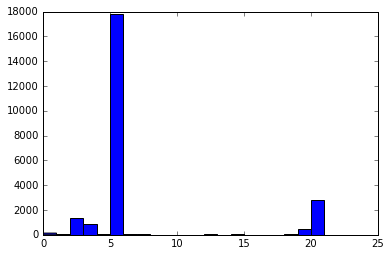

In [142]:
print(np.unique(y_patch))
plt.hist(y_patch, 21)

In [156]:
# Balanced classes
X_octree2 = np.empty((0, X_octree.shape[1]))
X_cov2 = np.empty((0,X_cov.shape[1]))

y2 = np.empty(0)
max_num = 500
min_sum=100
for c in np.unique(y_patch)[1:]:
    
    index = (y_patch==c)
    if(index.sum()>max_num):
        
        X_cov2 = np.vstack((X_cov2, X_cov[index][:max_num]))
        X_octree2 = np.vstack((X_octree2, X_octree[index][:max_num]))
        y2 = np.concatenate((y2, y_patch[index][:max_num]))
    elif(index.sum()> min_sum):
        
        X_cov2 = np.vstack((X_cov2, X_cov[index][:max_num]))
        X_octree2 = np.vstack((X_octree2, X_octree[index][:max_num]))
        y2 = np.concatenate((y2, y_patch[index][:max_num]))
    

(2474, 9) (23955, 9)
(2474, 4688) (23955, 4688)
(2474,)


(array([ 500.,  500.,    0.,  500.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,  474.,  500.]),
 array([  2.        ,   2.85714286,   3.71428571,   4.57142857,
          5.42857143,   6.28571429,   7.14285714,   8.        ,
          8.85714286,   9.71428571,  10.57142857,  11.42857143,
         12.28571429,  13.14285714,  14.        ,  14.85714286,
         15.71428571,  16.57142857,  17.42857143,  18.28571429,
         19.14285714,  20.        ]),
 <a list of 21 Patch objects>)

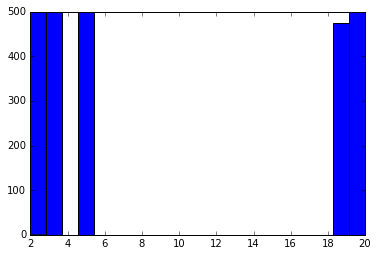

In [157]:
print(X_cov2.shape, X_cov.shape)
print(X_octree2.shape, X_octree.shape)
print(y2.shape)
plt.hist(y2, 21)

In [247]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import scipy

Normalized confusion matrix
[ 0.59649123  0.53846154  0.56790123  0.53877551  0.6259542 ]


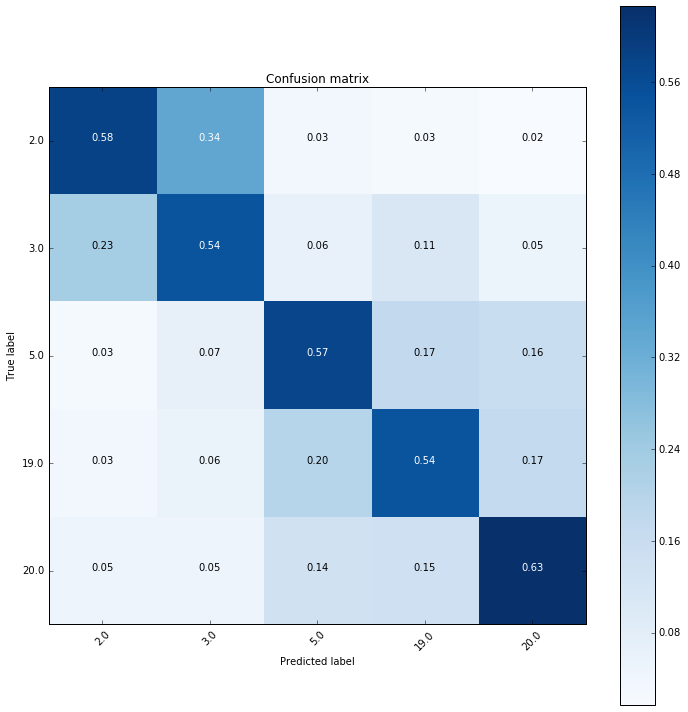

In [158]:
# For the covariance descriptor
X_train, X_val, y_train, y_val = train_test_split(X_cov2, y2)
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
plt.figure(figsize=(10,10))
a = confusion_matrix(y_pred, y_val)
plot_confusion_matrix(a, np.unique(y2), True)
print(f1_score(y_val, y_pred, average=None))

Normalized confusion matrix
[ 0.74590164  0.73962264  0.72727273  0.7257384   0.94252874]
[ 0.03379835  0.06769802  0.09786132  0.13693709  0.15040769  0.1017386
  0.16444263  0.2471163 ]


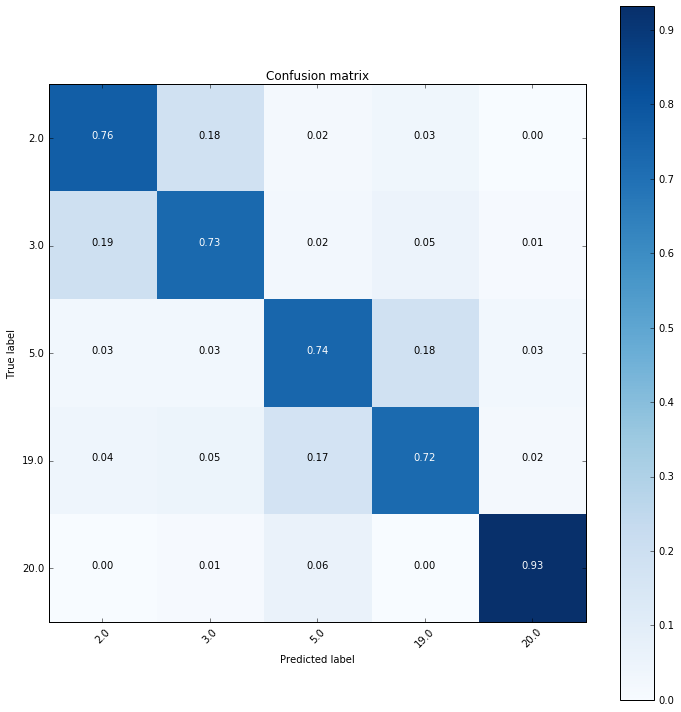

In [227]:
# For the ppl descriptor
X_train, X_val, y_train, y_val = train_test_split(X_octree2[:,:8], y2)
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
plt.figure(figsize=(10,10))
a = confusion_matrix(y_pred, y_val)
plot_confusion_matrix(a, np.unique(y2), True)
print(f1_score(y_val, y_pred, average=None))
print(rf.feature_importances_)

Normalized confusion matrix
[ 0.75652174  0.75675676  0.72463768  0.69958848  0.95652174]
[ 0.03616531  0.03965291  0.04154469  0.02603957  0.02884335  0.04255528
  0.04692221  0.15016511  0.03475329  0.01872919  0.02855633  0.07764091
  0.08852005  0.07234754  0.03619995  0.0618376   0.16952671]


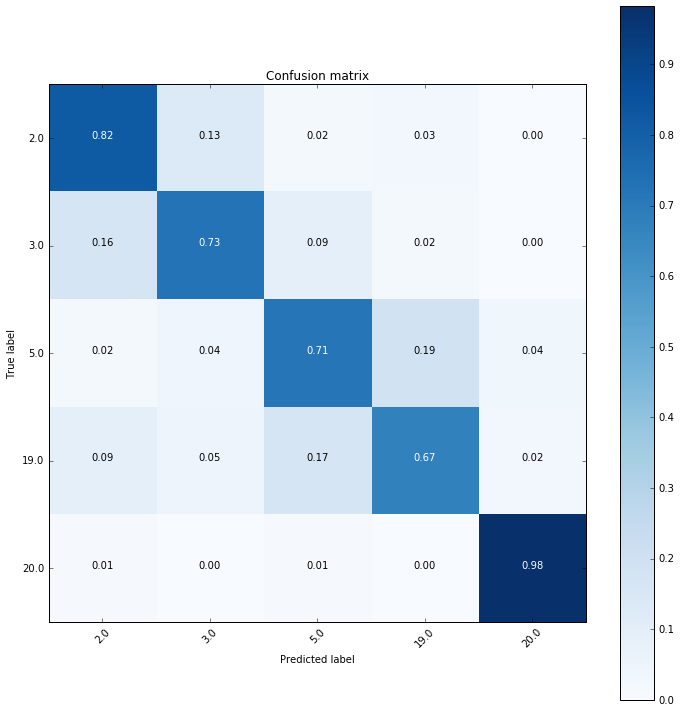

In [228]:
# We combine both
X_train, X_val, y_train, y_val = train_test_split(np.hstack((X_cov2,X_octree2[:,:8])), y2)
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
plt.figure(figsize=(10,10))
a = confusion_matrix(y_pred, y_val)
plot_confusion_matrix(a, np.unique(y2), True)
print(f1_score(y_val, y_pred, average=None))
print(rf.feature_importances_)

# Kernel

In [245]:
X_L1 = X_octree2[:,8:16]
X_L2 = X_octree2[:,16:80]
X_L3 = X_octree2[:,80:592]
X_L4 = X_octree2[:,592:]

K1 = 1 - scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X_L1,metric='cosine'))
K2 = 1 - scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X_L2,metric='cosine'))
K3 = 1 - scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X_L3,metric='cosine'))
K4 = 1 - scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X_L4,metric='cosine'))

In [265]:
def cosine(x, y):
    return x.dot(y)/(np.linalg.norm(x)*np.linalg.norm(y))

In [251]:
K = 0.5*K1++0.25*K2++0.125*K3+0.125*K4

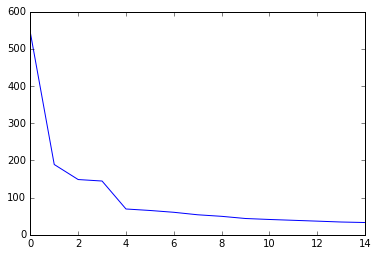

In [293]:
u, s, vt = np.linalg.svd(K4+K3)
plt.plot(s[:15])

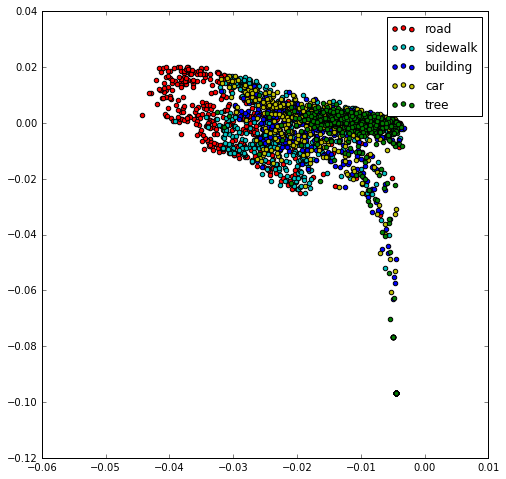

In [294]:
X = u[:, :2]
color = ['r','c','b', 'y', 'g', 'y']
plt.figure(figsize=(8,8))
for ind, c in enumerate(np.unique(y2)):
    plt.scatter(X[y2==c,0], X[y2==c,1], c=color[ind], label=dico[int(np.unique(old_y_patch)[int(c)])])
plt.legend()

In [297]:
write_ply('../data/kernel.ply',np.hstack((u[:,:3], y2.reshape(-1,1))),['x','y','z','label'])

True